In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./input\cs-test.csv
./input\cs-training.csv
./input\Data Dictionary.xls
./input\sampleEntry.csv


| 变量名称 | 变量描述 |
| --- | --- |
| id|序号|
| SeriousDlqin2yrs | 2年内有严重逾期行为 |
| RevolvingUtilizationOfUnsecuredLines | 无担保额度的循环使用情况 |
| age | 年龄 |
| NumberOfTime30-59DaysPastDueNotWorse | 逾期30-59天但未恶化的数量 |
| DebtRatio | 债务比 |
| MonthlyIncome | 月收入 |
| NumberOfOpenCreditLinesAndLoans | 未偿的信用额度和贷款的数量 |
| NumberOfTimes90DaysLate | 逾期90天的次数 |
| NumberRealEstateLoansOrLines | 房地产贷款或额度的数量 |
| NumberOfTime60-89DaysPastDueNotWorse | 逾期60-89天但未恶化的数量 |
| NumberOfDependents | 受扶养人的数量 |

1. [数据预处理](#数据预处理)
    1. [数据导入](#1a)
    1. [数据分析](#1b)
1. [EDA](#EDA)
    1. [age 年龄](#2a)
    1. [RevolvingUtilizationOfUnsecuredLines 无担保额度的循环使用情况](#2b)
    1. [DebtRatio 债务比率](#2c)
    1. [MonthlyIncome 月收入](#2d)
    1. [NumberOfOpenCreditLinesAndLoans 未偿的信用额度和贷款的数量](#2e)
    1. [NumberRealEstateLoansOrLines 房地产贷款或额度的数量](#2f)
    1. [NumberOfDependents 受扶养人的数量](#2g)
    1. [三个逾期指标](#2h)
1. [数据清洗](#数据清洗)
    1. [异常值处理](#3a)
    1. [缺失值处理](#3b)
1. [特征工程](#特征工程)
    1. [衍生变量](#4a)
    1. [数据分箱](#4b)
    1. [特征选取、变量筛选](#4c)
        1. [变量相关性](#4c1)
        1. [WOE、IV值计算](#4c2)
1. [模型构建](#模型构建)
    1. [数据集切分](#5a)
    1. [逻辑回归建模](#5b)
1. [模型评估](#模型评估)
    1. [ROC曲线、AUC值](#6a)
1. [评分卡](#评分卡)
    1. [参数换算](#参数换算)
    1. [评分卡生成](#评分卡生成)
1. [参考链接](#参考链接)

## 数据预处理<a class="anchor" id="1"></a>

In [2]:
df_train = pd.read_csv("./input/cs-training.csv")
df_test = pd.read_csv("./input/cs-test.csv")
df_train.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


### 数据分析<a class="anchor" id="1b"></a>

In [3]:
# 去重分析
print(df_train.duplicated().value_counts())
print(df_test.duplicated().value_counts())

False    150000
dtype: int64
False    101503
dtype: int64


In [4]:
# 数据概览，分析异常值
df_train.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,75000.500000,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,43301.414527,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

#### 初步分析结论
从上面的数据描述信息可以看出：
- 年龄 age 存在异常数据，最小值为0，最大值为109
- RevolvingUtilizationOfUnsecuredLines 应为0-1之间，最大值为50708，可能含有异常值
- NumberOfTime30-59DaysPastDueNotWorse、NumberOfTimes90DaysLate、NumberOfTime60-89DaysPastDueNotWorse 三个指标的最大值均为98，需要探查一下
- MonthlyIncome 和 NumberOfDependents 含有缺失值，缺失值的比例分别为 19.82% 和 2.62%

## EDA<a class="anchor" id="3"></a>

好坏样本占比，约有6%的样本违约，数据不平衡需处理

Default Rate: 6.68%


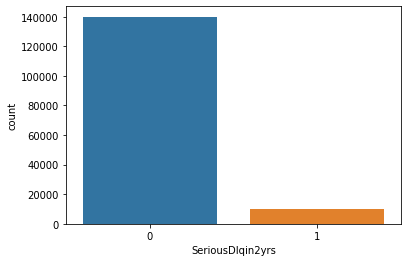

In [6]:
sns.countplot(x="SeriousDlqin2yrs", data=df_train)
print("Default Rate: {}%".format(round(df_train["SeriousDlqin2yrs"].sum()*100 / len(df_train), 2)))

### age 年龄<a class="anchor" id="2a"></a>

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='age'>

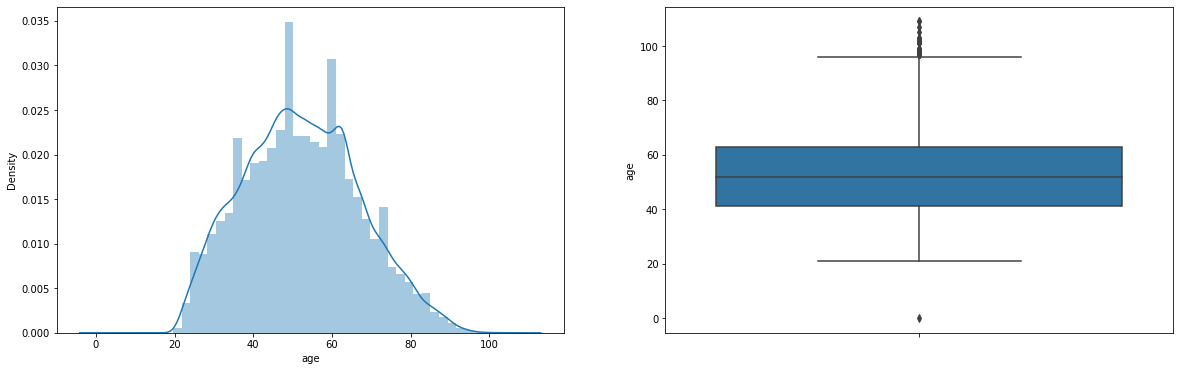

In [7]:
# 年龄分布情况
fig,[ax1,ax2]=plt.subplots(1,2,figsize=(20,6))
sns.distplot(df_train['age'],ax=ax1)
sns.boxplot(y='age',data=df_train,ax=ax2)

从以上分布来看，age的分布基本符合正态分布，用3倍标准差来筛选异常值

In [8]:
age_down = df_train['age'].mean() - 3 * df_train['age'].std()
age_up = df_train['age'].mean() + 3 * df_train['age'].std()
print("年龄下限设为：{}，年龄上限为：{}".format(age_down, age_up))

年龄下限设为：7.979609077364238，年龄上限为：96.6108042559691


In [9]:
# 查询年龄异常数据比例
df_agedown = df_train.loc[df_train['age']<age_down,:]
df_ageup = df_train.loc[df_train['age']>age_up,:]
print("小于异常下限比例：{}%".format(df_agedown.shape[0]*100/df_train.shape[0]))
print("大于异常上限比例：{}%".format(df_ageup.shape[0]*100/df_train.shape[0]))

小于异常下限比例：0.0006666666666666666%
大于异常上限比例：0.03%


In [10]:
print(df_agedown.shape, df_ageup.shape)

(1, 12) (45, 12)


In [11]:
df_agedown

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
65695,65696,0,1.0,0,1,0.436927,6000.0,6,0,2,0,2.0


In [12]:
df_ageup.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
436,437,0,0.007000,97,0,3.000000,NaN,2,0,0,0,NaN
2922,2923,0,0.005043,99,0,800.000000,NaN,5,0,0,0,NaN
7763,7764,0,0.069167,101,0,50.000000,NaN,2,0,0,0,0.0
9359,9360,0,0.000000,97,0,0.000000,0.0,3,0,0,0,0.0
9870,9871,0,0.012737,98,0,0.006503,2152.0,6,0,0,0,0.0


只有一条数据小于年龄异常下限，该数据年龄为0，可以删除处理。年龄超出上限有45条，存在噪声

对年龄做分组查看：

<AxesSubplot:xlabel='age'>

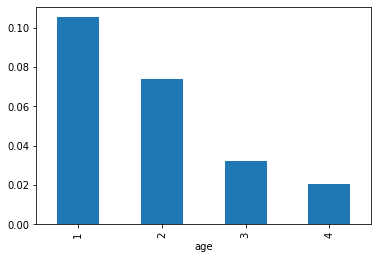

In [13]:
df_age = df_train.loc[df_train['age'] > 0, ['age', 'SeriousDlqin2yrs']] # age=0不考虑
df_age.loc[(df_age['age']>18) & (df_age['age']<40), 'age'] = 1
df_age.loc[(df_age['age']>=40) & (df_age['age']<60), 'age'] = 2
df_age.loc[(df_age['age']>=60) & (df_age['age']<80), 'age'] = 3
df_age.loc[(df_age['age']>=80), 'age'] = 4

label_by_age_group = df_age.groupby('age')['SeriousDlqin2yrs'].sum()
count_by_age_group = df_age.groupby('age')['SeriousDlqin2yrs'].count()
ratio_by_age_group = label_by_age_group / count_by_age_group

ratio_by_age_group.plot(kind='bar')

可以看出违约率随着年龄增长而下降，符合预期

### RevolvingUtilizationOfUnsecuredLines 无担保额度的循环使用情况<a class="anchor" id="2b"></a>

该指标为信用卡和个人信贷额度的总余额，除了房地产和没有分期付款的债务如汽车贷款，除以信贷限额的总和。

In [14]:
df_train["RevolvingUtilizationOfUnsecuredLines"].describe()

count    150000.000000
mean          6.048438
std         249.755371
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

理论上为0到1之间的值，但是这里出现了很大的数字，大于1表示透支，有不少数据超过了10000

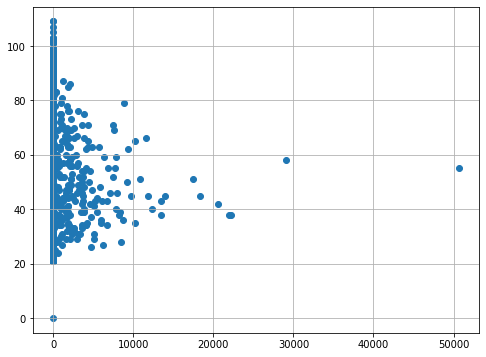

In [15]:
# 用散点图看一下
plt.figure(figsize=(8,6))
plt.scatter(df_train['RevolvingUtilizationOfUnsecuredLines'], df_train['age'])
plt.grid()

In [16]:
# 四分位距查看异常值
percent_25 = np.percentile(df_train['RevolvingUtilizationOfUnsecuredLines'], 25)
percent_75 = np.percentile(df_train['RevolvingUtilizationOfUnsecuredLines'], 75)
revol_down = percent_25 - 1.5*(percent_75 - percent_25)
revol_up = percent_75 + 1.5*(percent_75 - percent_25)
print('异常值下限值：', revol_down, '异常值上限值：', revol_up)

异常值下限值： -0.7639007662499999 异常值上限值： 1.35281445575


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='RevolvingUtilizationOfUnsecuredLines', ylabel='Density'>

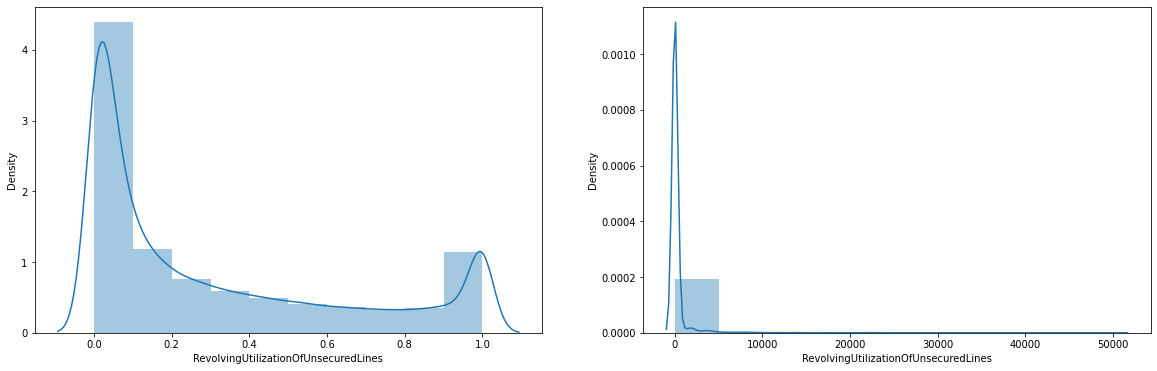

In [17]:
#将数据分为两部分，小于1和大于1的部分
data1 = df_train.loc[df_train['RevolvingUtilizationOfUnsecuredLines']<1,:]
data2 = df_train.loc[df_train['RevolvingUtilizationOfUnsecuredLines']>=1,:]

#看一下两部分数据分布情况
fig=plt.figure(figsize=(20,6))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
sns.distplot(data1['RevolvingUtilizationOfUnsecuredLines'],ax=ax1,bins=10)
sns.distplot(data2['RevolvingUtilizationOfUnsecuredLines'],ax=ax2,bins=10)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

<AxesSubplot:xlabel='RevolvingUtilizationOfUnsecuredLines', ylabel='Density'>

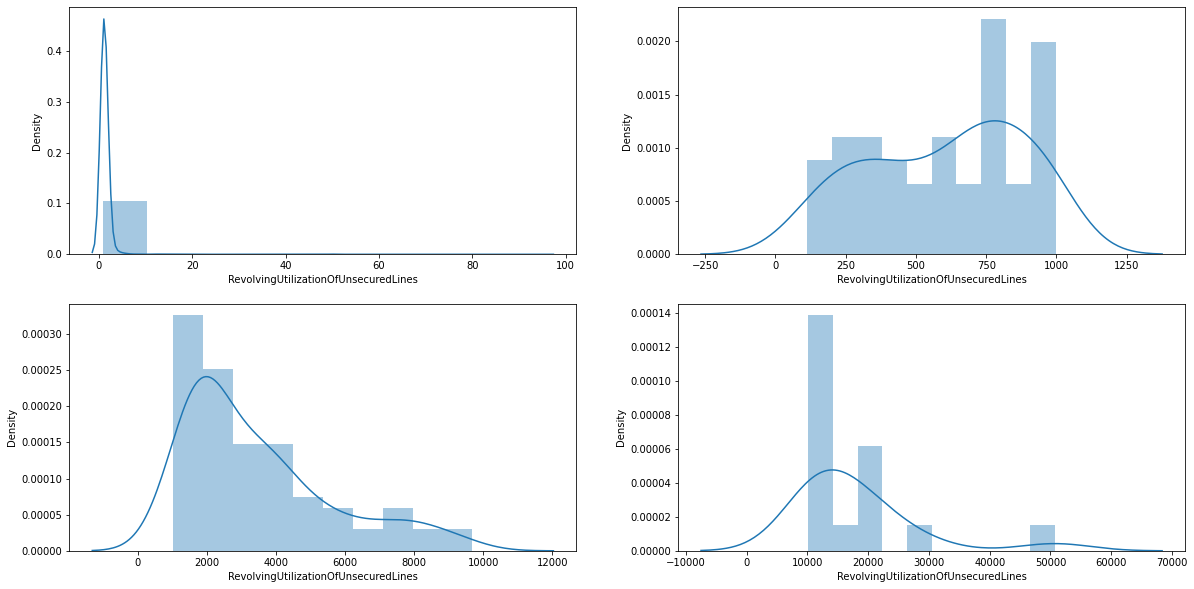

In [18]:
fig,[[ax1,ax2],[ax3,ax4]]=plt.subplots(2,2,figsize=(20,10))
sns.distplot(df_train.loc[(df_train['RevolvingUtilizationOfUnsecuredLines']>=1)&(df_train['RevolvingUtilizationOfUnsecuredLines']<100),'RevolvingUtilizationOfUnsecuredLines'],bins=10,ax=ax1)
sns.distplot(df_train.loc[(df_train['RevolvingUtilizationOfUnsecuredLines']>=100)&(df_train['RevolvingUtilizationOfUnsecuredLines']<1000),'RevolvingUtilizationOfUnsecuredLines'],bins=10,ax=ax2)
sns.distplot(df_train.loc[(df_train['RevolvingUtilizationOfUnsecuredLines']>=1000)&(df_train['RevolvingUtilizationOfUnsecuredLines']<10000),'RevolvingUtilizationOfUnsecuredLines'],bins=10,ax=ax3)
sns.distplot(df_train.loc[df_train['RevolvingUtilizationOfUnsecuredLines']>=10000,'RevolvingUtilizationOfUnsecuredLines'],bins=10,ax=ax4)

大于1的数据绝大多数数据集中在1-20之间，目的是找到异常值的阈值，分区间看一下违约率情况。

In [19]:
#将区间分为（0-1），(1-10),（10-20），（20-100），（100,1000），（1000-10000），（10000,51000）看一下违约率情况
data_1=df_train.loc[(df_train['RevolvingUtilizationOfUnsecuredLines']>=0)&(df_train['RevolvingUtilizationOfUnsecuredLines']<1),:]
Is_1=data_1.loc[data_1['SeriousDlqin2yrs']==1,:].shape[0]*100/data_1.shape[0]

data_2=df_train.loc[(df_train['RevolvingUtilizationOfUnsecuredLines']>=1)&(df_train['RevolvingUtilizationOfUnsecuredLines']<10),:]
Is_2=data_2.loc[data_2['SeriousDlqin2yrs']==1,:].shape[0]*100/data_2.shape[0]

data_3=df_train.loc[(df_train['RevolvingUtilizationOfUnsecuredLines']>=10)&(df_train['RevolvingUtilizationOfUnsecuredLines']<20),:]
Is_3=data_3.loc[data_3['SeriousDlqin2yrs']==1,:].shape[0]*100/data_3.shape[0]

data_4=df_train.loc[(df_train['RevolvingUtilizationOfUnsecuredLines']>=20)&(df_train['RevolvingUtilizationOfUnsecuredLines']<100),:]
Is_4=data_4.loc[data_4['SeriousDlqin2yrs']==1,:].shape[0]*100/data_4.shape[0]

data_5=df_train.loc[(df_train['RevolvingUtilizationOfUnsecuredLines']>=100)&(df_train['RevolvingUtilizationOfUnsecuredLines']<1000),:]
Is_5=data_5.loc[data_5['SeriousDlqin2yrs']==1,:].shape[0]*100/data_5.shape[0]

data_6=df_train.loc[(df_train['RevolvingUtilizationOfUnsecuredLines']>=1000)&(df_train['RevolvingUtilizationOfUnsecuredLines']<10000),:]
Is_6=data_6.loc[data_6['SeriousDlqin2yrs']==1,:].shape[0]*100/data_6.shape[0]

data_7=df_train.loc[(df_train['RevolvingUtilizationOfUnsecuredLines']>=10000)&(df_train['RevolvingUtilizationOfUnsecuredLines']<51000),:]
Is_7=data_7.loc[data_7['SeriousDlqin2yrs']==1,:].shape[0]*100/data_7.shape[0]

print('0-1违约率为：{0}%'.format(Is_1))
print('1-10违约率为：{0}%'.format(Is_2))
print('10-20违约率为：{0}%'.format(Is_3))
print('20-100违约率为：{0}%'.format(Is_4))
print('100-1000违约率为：{0}%'.format(Is_5))
print('1000-10000违约率为：{0}%'.format(Is_6))
print('10000-51000违约率为：{0}%'.format(Is_7))

0-1违约率为：5.989963317014633%
1-10违约率为：39.52211817888279%
10-20违约率为：57.142857142857146%
20-100违约率为：18.181818181818183%
100-1000违约率为：1.9607843137254901%
1000-10000违约率为：6.410256410256411%
10000-51000违约率为：0.0%


可以看出在RevolvingUtilizationOfUnsecuredLines大于1时，违约率开始上升，10-20之间违约率达到高峰，超过20后开始下降，超过1000后开始恢复正常（与0-1的违约率一致），说明20左右的值可能为异常值上限的阈值。可以将超过20的值都定义为异常值。

### DebtRatio 债务比率<a class="anchor" id="2c"></a>

In [20]:
df_train["DebtRatio"].describe()

count    150000.000000
mean        353.005076
std        2037.818523
min           0.000000
25%           0.175074
50%           0.366508
75%           0.868254
max      329664.000000
Name: DebtRatio, dtype: float64

<AxesSubplot:ylabel='DebtRatio'>

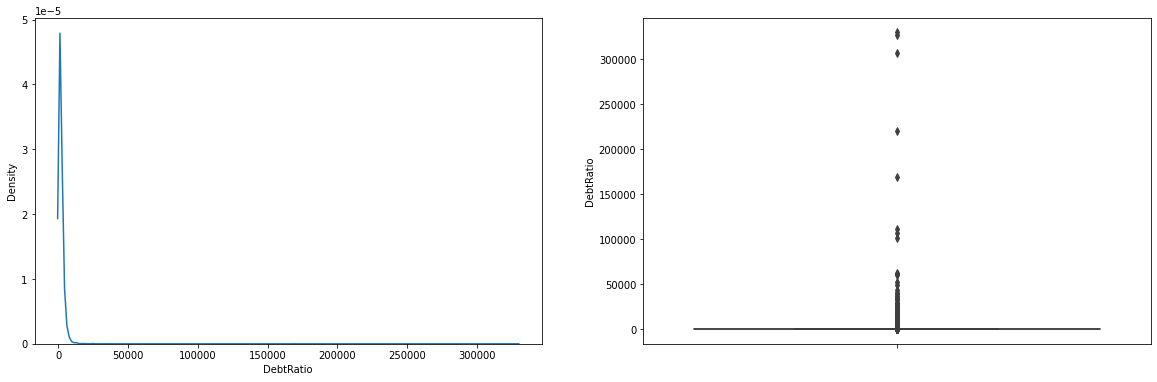

In [21]:
#DebtRatio数据的分布情况
fig,[ax1,ax2]=plt.subplots(1,2,figsize=(20,6))
sns.kdeplot(df_train['DebtRatio'],ax=ax1)
sns.boxplot(y=df_train['DebtRatio'],ax=ax2)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='DebtRatio', ylabel='Density'>

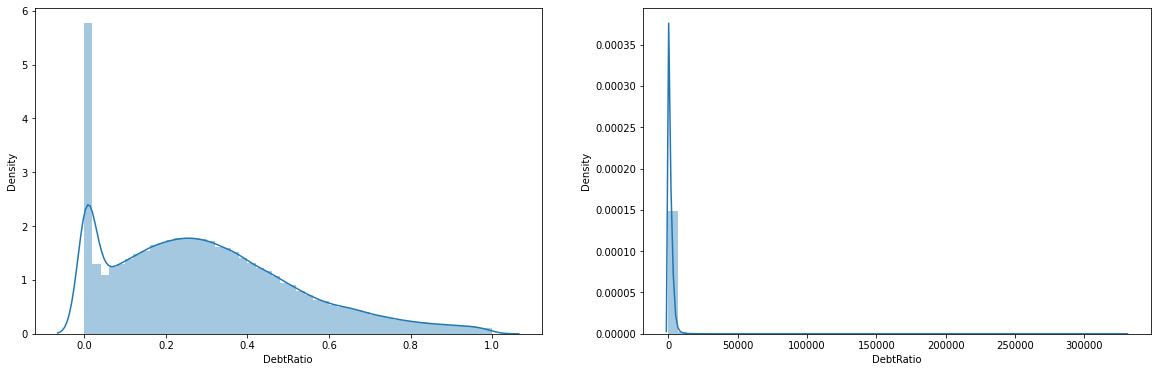

In [22]:
# 数据分布跨度较大，分组查看数据分布情况
Debt1=df_train.loc[df_train['DebtRatio']<1,:]
Debt2=df_train.loc[df_train['DebtRatio']>=1,:]
fig,[ax1,ax2]=plt.subplots(1,2,figsize=(20,6))
sns.distplot(Debt1['DebtRatio'],ax=ax1)
sns.distplot(Debt2['DebtRatio'],ax=ax2)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

<AxesSubplot:xlabel='DebtRatio', ylabel='Density'>

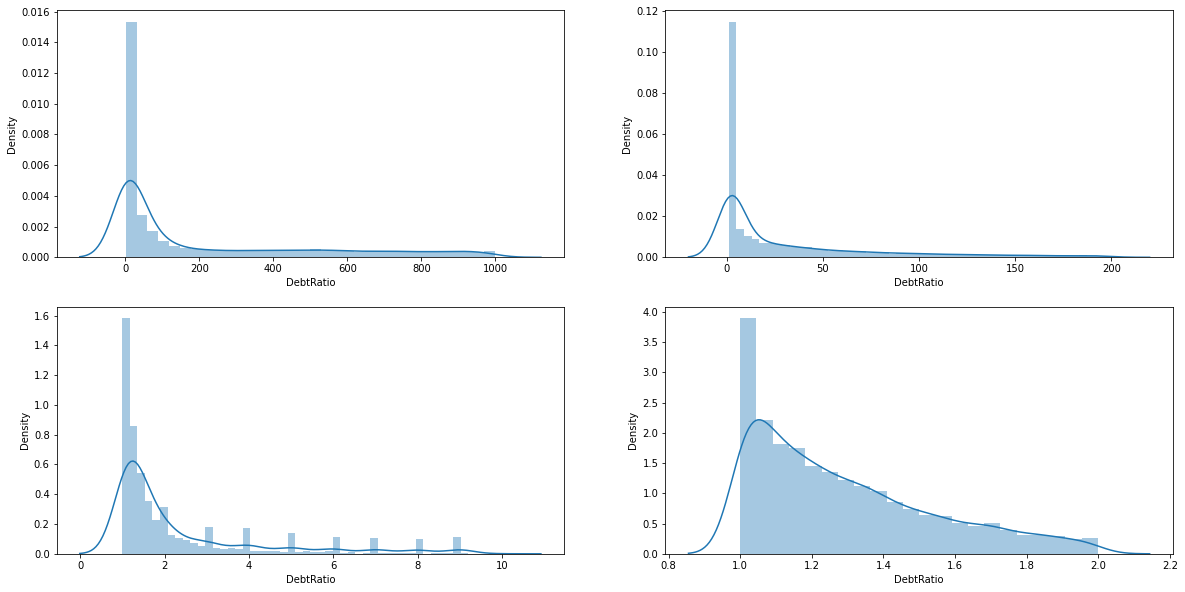

In [23]:
#尝试多次细分
Debt3=df_train.loc[(df_train['DebtRatio']>=1)&(df_train['DebtRatio']<1000),:]
Debt4=df_train.loc[(df_train['DebtRatio']>=1)&(df_train['DebtRatio']<200),:]
Debt5=df_train.loc[(df_train['DebtRatio']>=1)&(df_train['DebtRatio']<10),:]
Debt6=df_train.loc[(df_train['DebtRatio']>=1)&(df_train['DebtRatio']<2),:]

fig,[[ax1,ax2],[ax3,ax4]]=plt.subplots(2,2,figsize=(20,10))
sns.distplot(Debt3['DebtRatio'],ax=ax1)
sns.distplot(Debt4['DebtRatio'],ax=ax2)
sns.distplot(Debt5['DebtRatio'],ax=ax3)
sns.distplot(Debt6['DebtRatio'],ax=ax4)

In [24]:
#各区间的违约率(0,1),(1-2),(2-10),(10-50),(50-200),(200,1000),1000以上
Debt_1=df_train.loc[(df_train['DebtRatio']>=0)&(df_train['DebtRatio']<1),:]
DebIs_1=Debt_1.loc[Debt_1['SeriousDlqin2yrs']==1,:].shape[0]*100/Debt_1.shape[0]

Debt_2=df_train.loc[(df_train['DebtRatio']>=1)&(df_train['DebtRatio']<2),:]
DebIs_2=Debt_2.loc[Debt_2['SeriousDlqin2yrs']==1,:].shape[0]*100/Debt_2.shape[0]

Debt_3=df_train.loc[(df_train['DebtRatio']>=2)&(df_train['DebtRatio']<10),:]
DebIs_3=Debt_3.loc[Debt_3['SeriousDlqin2yrs']==1,:].shape[0]*100/Debt_3.shape[0]

Debt_4=df_train.loc[(df_train['DebtRatio']>=10)&(df_train['DebtRatio']<50),:]
DebIs_4=Debt_4.loc[Debt_4['SeriousDlqin2yrs']==1,:].shape[0]*100/Debt_4.shape[0]

Debt_5=df_train.loc[(df_train['DebtRatio']>=50)&(df_train['DebtRatio']<200),:]
DebIs_5=Debt_5.loc[Debt_5['SeriousDlqin2yrs']==1,:].shape[0]*100/Debt_5.shape[0]

Debt_6=df_train.loc[(df_train['DebtRatio']>=200)&(df_train['DebtRatio']<1000),:]
DebIs_6=Debt_6.loc[Debt_6['SeriousDlqin2yrs']==1,:].shape[0]*100/Debt_6.shape[0]

Debt_7=df_train.loc[df_train['DebtRatio']>=1000,:]
DebIs_7=Debt_7.loc[Debt_7['SeriousDlqin2yrs']==1,:].shape[0]*100/Debt_7.shape[0]

print('0-1违约率为：{0}%'.format(DebIs_1))
print('1-2违约率为：{0}%'.format(DebIs_2))
print('2-10违约率为：{0}%'.format(DebIs_3)) 
print('10-50违约率为：{0}%'.format(DebIs_4))
print('50-200违约率为：{0}%'.format(DebIs_5))
print('200-1000违约率为：{0}%'.format(DebIs_6))
print('1000以上违约率为：{0}%'.format(DebIs_7))

0-1违约率为：6.744944780780571%
1-2违约率为：13.008913514815706%
2-10违约率为：6.2584421431787485%
10-50违约率为：4.346383543463835%
50-200违约率为：5.62695380340396%
200-1000违约率为：7.950330591840026%
1000以上违约率为：4.905325443786983%


可以看到1-2的违约率达到最高，超过2以后违约率开始稳定，可以把2作为异常值上限的阈值。并把大于2的数据和0-1的数据进行合并。

### MonthlyIncome 月收入<a class="anchor" id="2d"></a>

<AxesSubplot:ylabel='MonthlyIncome'>

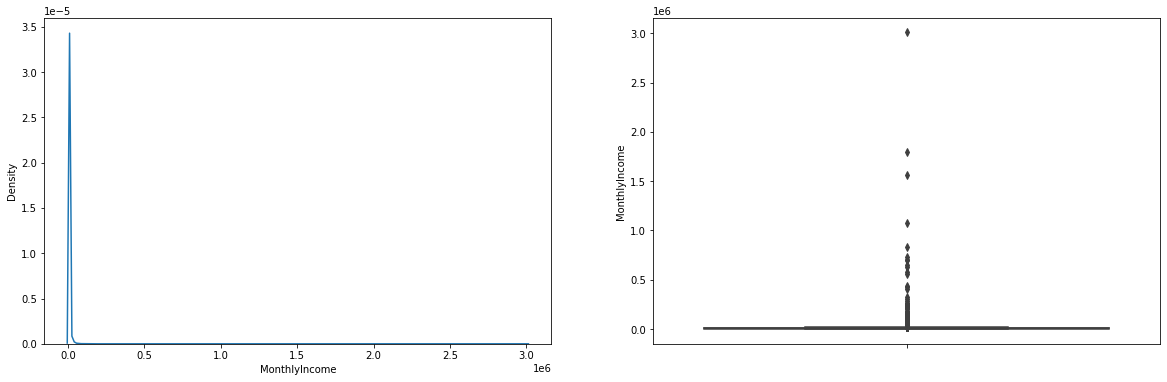

In [25]:
#MonthlyIncome数据分布
fig,[ax1,ax2]=plt.subplots(1,2,figsize=(20,6))
sns.kdeplot(df_train['MonthlyIncome'],ax=ax1)
sns.boxplot(y=df_train['MonthlyIncome'],ax=ax2)

In [26]:
# MonthlyIncome缺失值情况
M_nullNum=df_train['MonthlyIncome'].isnull().sum()
print('缺失值数量：',M_nullNum,'缺失值比率：{0}%'.format(M_nullNum*100/df_train.shape[0]))

缺失值数量： 29731 缺失值比率：19.820666666666668%


缺失值比率达到20%，不能直接删除，可以采用随机森林填补缺失值。

### NumberOfOpenCreditLinesAndLoans 未偿的信用额度和贷款的数量<a class="anchor" id="2e"></a>

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='NumberOfOpenCreditLinesAndLoans'>

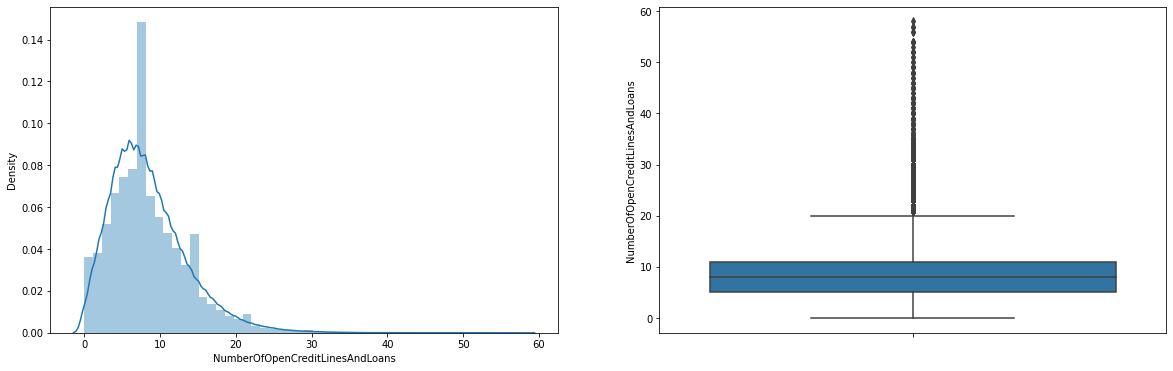

In [27]:
# 数据分布
fig,[ax1,ax2]=plt.subplots(1,2,figsize=(20,6))
sns.distplot(df_train['NumberOfOpenCreditLinesAndLoans'],ax=ax1)
sns.boxplot(y=df_train['NumberOfOpenCreditLinesAndLoans'],ax=ax2)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='NumberOfOpenCreditLinesAndLoans', ylabel='count'>

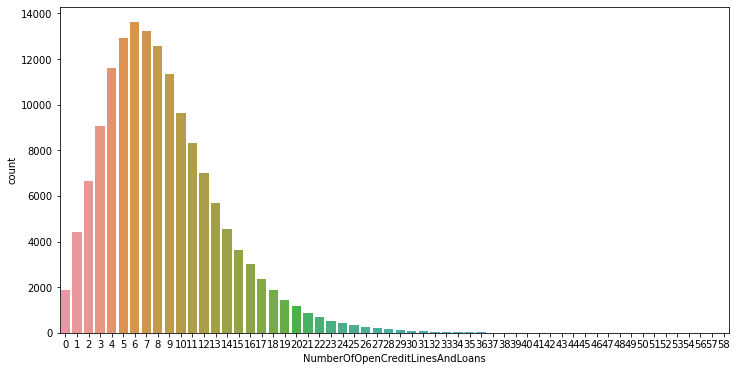

In [28]:
#看一下数据点分布
figure=plt.figure(figsize=(12,6))
sns.countplot(df_train['NumberOfOpenCreditLinesAndLoans'])

<AxesSubplot:xlabel='NumberOfOpenCreditLinesAndLoans'>

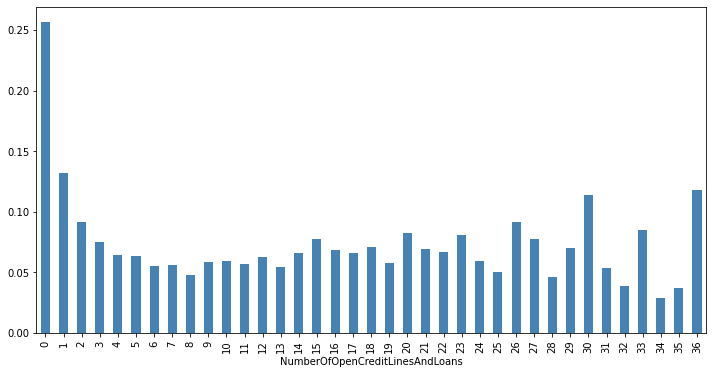

In [29]:
# 可以看出大于36的数据过少，把大于36的数据和36合并，看一下违约率的情况
df_train.loc[df_train['NumberOfOpenCreditLinesAndLoans']>36,'NumberOfOpenCreditLinesAndLoans']=36
Numopen_dlq=df_train.groupby(['NumberOfOpenCreditLinesAndLoans'])['SeriousDlqin2yrs'].sum()
Numopen_total=df_train.groupby(['NumberOfOpenCreditLinesAndLoans'])['SeriousDlqin2yrs'].count()
Numopen_dlqratio=Numopen_dlq/Numopen_total
Numopen_dlqratio.plot(kind='bar',figsize=(12,6),color='#4682B4')

### NumberRealEstateLoansOrLines 房地产贷款或额度的数量<a class="anchor" id="2f"></a>

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='NumberRealEstateLoansOrLines'>

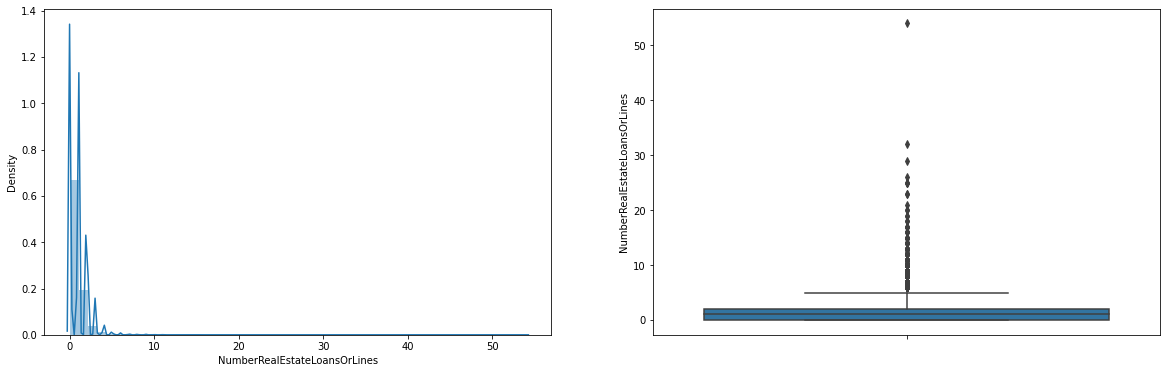

In [30]:
#数据分布
fig,[ax1,ax2]=plt.subplots(1,2,figsize=(20,6))
sns.distplot(df_train['NumberRealEstateLoansOrLines'],ax=ax1)
sns.boxplot(y=df_train['NumberRealEstateLoansOrLines'],ax=ax2)

可以看到超过50的点为明显的异常点

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='NumberRealEstateLoansOrLines', ylabel='count'>

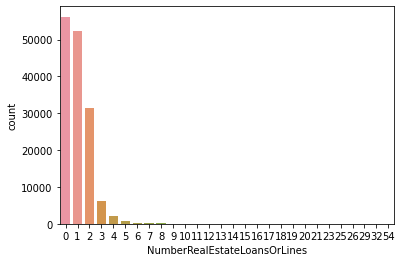

In [31]:
#大致看一下各数据点数据大小分布
sns.countplot(df_train['NumberRealEstateLoansOrLines'])

<AxesSubplot:xlabel='NumberRealEstateLoansOrLines'>

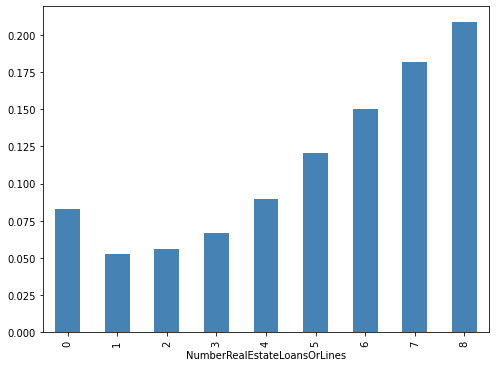

In [32]:
# 将大于8的数据和8合并后看一下违约率的情况
df_train.loc[df_train['NumberRealEstateLoansOrLines']>8,'NumberRealEstateLoansOrLines']=8
Numestate_dlq=df_train.groupby(['NumberRealEstateLoansOrLines'])['SeriousDlqin2yrs'].sum()
Numestate_total=df_train.groupby(['NumberRealEstateLoansOrLines'])['SeriousDlqin2yrs'].count()
Numestate_dlqratio=Numestate_dlq/Numestate_total
Numestate_dlqratio.plot(kind='bar',figsize=(8,6),color='#4682B4')

从 NumberOfOpenCreditLinesAndLoans 和 NumberRealEstateLoansOrLines 的违约率分布可以看出，贷款数量为0时并不是违约率最低的，不动产贷款数量为1时违约率最低，但随着打款数量增加，违约率也随着增高。

### NumberOfDependents 受扶养人的数量<a class="anchor" id="2g"></a>

In [33]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

由描述统计信息，NumberOfDependents 存在缺失值，缺失值数量为 3924，缺失率为 2.616%

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='NumberOfDependents'>

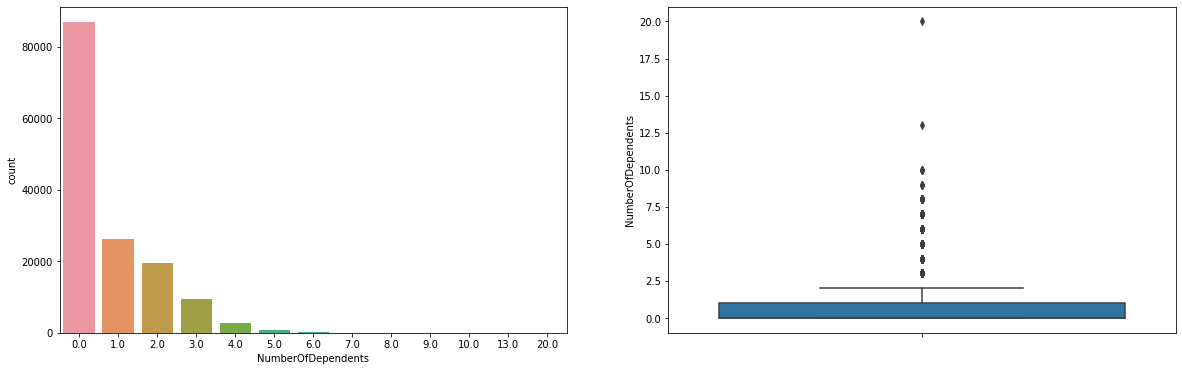

In [34]:
# NumberOfDependents 数据分布
fig,[ax1,ax2]=plt.subplots(1,2,figsize=(20,6))
sns.countplot(df_train['NumberOfDependents'],ax=ax1)
sns.boxplot(y=df_train['NumberOfDependents'],ax=ax2)

In [35]:
# 看一下 MonthlyIncome和 NumberOfDependents 的缺失是否有关联
df_train.loc[(df_train['NumberOfDependents'].isnull()) & (df_train['MonthlyIncome'].isnull()),:].shape[0]

3924

可以看出 NumberOfDependents 缺失的，MonthlyIncome也同时缺失。看一下MonthlyIncome缺失，NumberOfDependents 不缺失的数据分布：

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='NumberOfDependents', ylabel='count'>

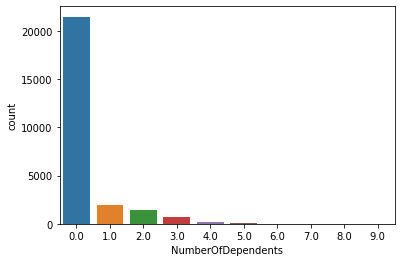

In [36]:
MonthNullDependNot=df_train.loc[(df_train['NumberOfDependents'].notnull())&(df_train['MonthlyIncome']).isnull(),:]
sns.countplot(MonthNullDependNot['NumberOfDependents'])

可以看出MonthlyIncome缺失，NumberOfDependents 不缺失的数据中 NumberOfDependents 大多取值0，所以可以们将 NumberOfDependents 的缺失值填充为0。

### 三个逾期指标<a class="anchor" id="2h"></a>

- NumberOfTime30-59DaysPastDueNotWorse 逾期30-59天但未恶化的数量
- NumberOfTime60-89DaysPastDueNotWorse 逾期60-89天但未恶化的数量
- NumberOfTimes90DaysLate 逾期90天的次数

可以看出大于90的为明显的异常值

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='NumberOfTime30-59DaysPastDueNotWorse'>

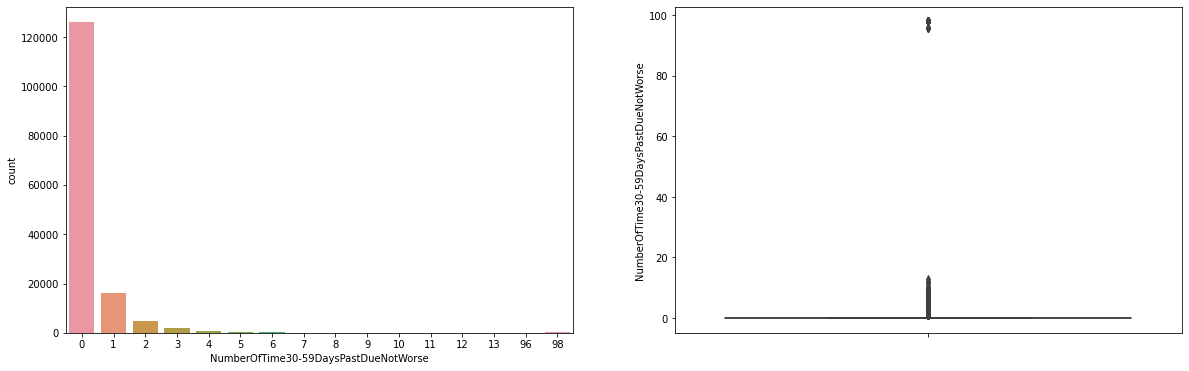

In [37]:
# NumberOfTime30-59DaysPastDueNotWorse 逾期30-59天但未恶化的数量
fig,[ax1,ax2]=plt.subplots(1,2,figsize=(20,6))
sns.countplot(df_train['NumberOfTime30-59DaysPastDueNotWorse'],ax=ax1)
sns.boxplot(y=df_train['NumberOfTime30-59DaysPastDueNotWorse'],ax=ax2)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='NumberOfTime60-89DaysPastDueNotWorse'>

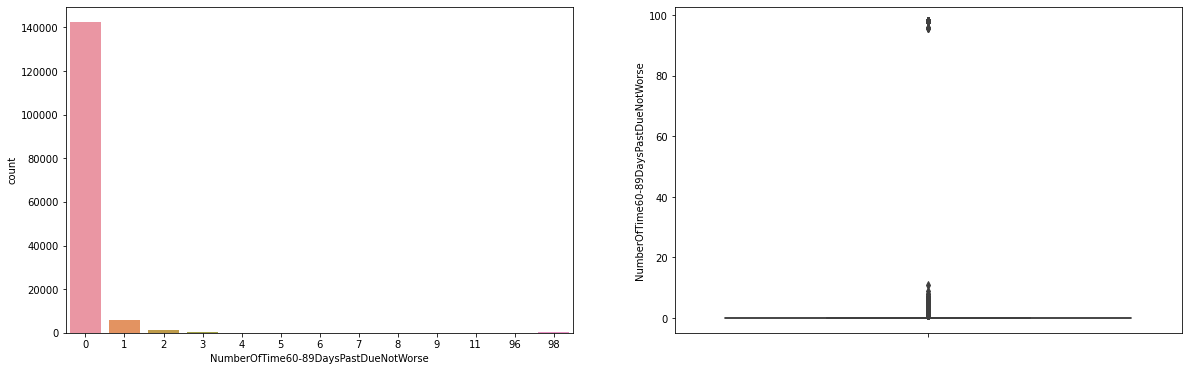

In [38]:
# NumberOfTime60-89DaysPastDueNotWorse 逾期60-89天但未恶化的数量
fig,[ax1,ax2]=plt.subplots(1,2,figsize=(20,6))
sns.countplot(df_train['NumberOfTime60-89DaysPastDueNotWorse'],ax=ax1)
sns.boxplot(y=df_train['NumberOfTime60-89DaysPastDueNotWorse'],ax=ax2)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='NumberOfTimes90DaysLate'>

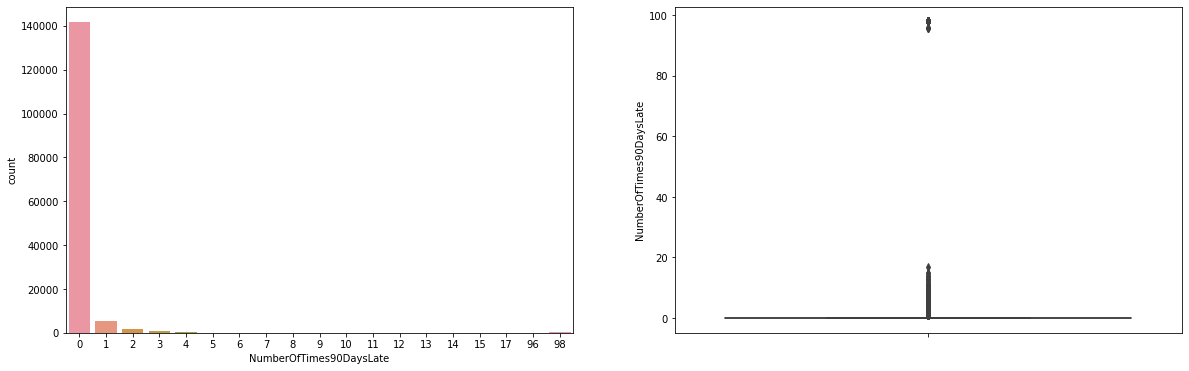

In [39]:
# NumberOfTimes90DaysLate 逾期90天的次数
fig,[ax1,ax2]=plt.subplots(1,2,figsize=(20,6))
sns.countplot(df_train['NumberOfTimes90DaysLate'],ax=ax1)
sns.boxplot(y=df_train['NumberOfTimes90DaysLate'],ax=ax2)

### 数据清洗<a class="anchor" id="3"></a>

#### 异常值处理<a class="anchor" id="3a"></a>

In [40]:
# age异常值处理
df_train=df_train[df_train['age']>0]

# 三个逾期指标的异常值处理
# NumberOfTime30-59DaysPastDueNotWorse
# NumberOfTime60-89DaysPastDueNotWorse
# NumberOfTimes90DaysLate
df_train=df_train[df_train['NumberOfTime30-59DaysPastDueNotWorse']<90]
df_train=df_train[df_train['NumberOfTime60-89DaysPastDueNotWorse']<90]
df_train=df_train[df_train['NumberOfTimes90DaysLate']<90]

# NumberRealEstateLoansOrLines 异常值处理
df_train=df_train[df_train['NumberRealEstateLoansOrLines']<50]

#### 缺失值处理<a class="anchor" id="3b"></a>

In [41]:
# NumberOfDependents 缺失值处理
df_train['NumberOfDependents']=df_train['NumberOfDependents'].fillna('0')

# MonthlyIncome缺失值处理
# 随机森林预测缺失值
df_Forest=df_train.iloc[:,[6,1,2,3,4,5,7,8,9]]
MonthlyIncome_isnull=df_Forest.loc[df_train['MonthlyIncome'].isnull(),:]
MonthlyIncome_notnull=df_Forest.loc[df_train['MonthlyIncome'].notnull(),:]

from sklearn.ensemble import RandomForestRegressor
X=MonthlyIncome_notnull.iloc[:,1:].values
y=MonthlyIncome_notnull.iloc[:,0].values
regr=RandomForestRegressor(max_depth=3, random_state=0,n_estimators=200,n_jobs=-1)
regr.fit(X,y)
MonthlyIncome_fillvalue=regr.predict(MonthlyIncome_isnull.iloc[:,1:].values).round(0)

# 填充 MonthlyIncome 缺失值
df_train.loc[df_train['MonthlyIncome'].isnull(),'MonthlyIncome']=MonthlyIncome_fillvalue

### 特征工程<a class="anchor" id="4"></a>

#### 衍生变量<a class="anchor" id="4a"></a>

In [42]:
df_train['NumLate']=df_train['NumberOfTime30-59DaysPastDueNotWorse']+df_train['NumberOfTime60-89DaysPastDueNotWorse']+df_train['NumberOfTimes90DaysLate']
df_train['MonthlyPayment']=df_train['DebtRatio']*df_train['MonthlyIncome']

#### 数据分箱<a class="anchor" id="4b"></a>

In [43]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149730 entries, 0 to 149999
Data columns (total 14 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            149730 non-null  int64  
 1   SeriousDlqin2yrs                      149730 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  149730 non-null  float64
 3   age                                   149730 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  149730 non-null  int64  
 5   DebtRatio                             149730 non-null  float64
 6   MonthlyIncome                         149730 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       149730 non-null  int64  
 8   NumberOfTimes90DaysLate               149730 non-null  int64  
 9   NumberRealEstateLoansOrLines          149730 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  149730 non-null  int64  
 11  

In [44]:
# 数据类型转换
df_train['NumberOfDependents']=df_train['NumberOfDependents'].astype('int64')
df_train['MonthlyIncome']=df_train['MonthlyIncome'].astype('int64')
df_train['MonthlyPayment']=df_train['MonthlyPayment'].astype('int64')

In [45]:
# RevolvingUtilizationOfUnsecuredLines 分箱
# 根据前文EDA分析，将大于20的数据与0-1的数据合并
df_train.loc[(df_train['RevolvingUtilizationOfUnsecuredLines']<1),'RevolvingUtilizationOfUnsecuredLines']=0
df_train.loc[(df_train['RevolvingUtilizationOfUnsecuredLines']>1)&(df_train['RevolvingUtilizationOfUnsecuredLines']<=20),'RevolvingUtilizationOfUnsecuredLines']=1
df_train.loc[(df_train['RevolvingUtilizationOfUnsecuredLines']>20),'RevolvingUtilizationOfUnsecuredLines']=0 

# DebtRatio 分箱
df_train.loc[(df_train['DebtRatio']<1),'DebtRatio']=0
df_train.loc[(df_train['DebtRatio']>1)&(df_train['DebtRatio']<2),'DebtRatio']=1
df_train.loc[(df_train['DebtRatio']>=2),'DebtRatio']=0

# NumberOfTime30-59DaysPastDueNotWorse 
# NumberOfTime60-89DaysPastDueNotWorse
# NumberOfTimes90DaysLate
# NumberRealEstateLoansOrLines
# NumberOfDependents
df_train.loc[(df_train['NumberOfTime30-59DaysPastDueNotWorse']>=8), 'NumberOfTime30-59DaysPastDueNotWorse'] = 8
df_train.loc[(df_train['NumberOfTime60-89DaysPastDueNotWorse']>=7), 'NumberOfTime60-89DaysPastDueNotWorse'] = 7
df_train.loc[(df_train['NumberOfTimes90DaysLate']>=10), 'NumberOfTimes90DaysLate'] = 10
df_train.loc[(df_train['NumberRealEstateLoansOrLines']>=8), 'NumberRealEstateLoansOrLines'] = 8
df_train.loc[(df_train['NumberOfDependents']>=7), 'NumberOfDependents'] = 7

# NumLate 分箱
df_train.loc[(df_train['NumLate']>1),'NumLate']=1 # 分为逾期和未逾期两种情况

#### 特征选择、变量筛选<a class="anchor" id="4c"></a>

##### 变量相关性<a class="anchor" id="4c1"></a>

<AxesSubplot:>

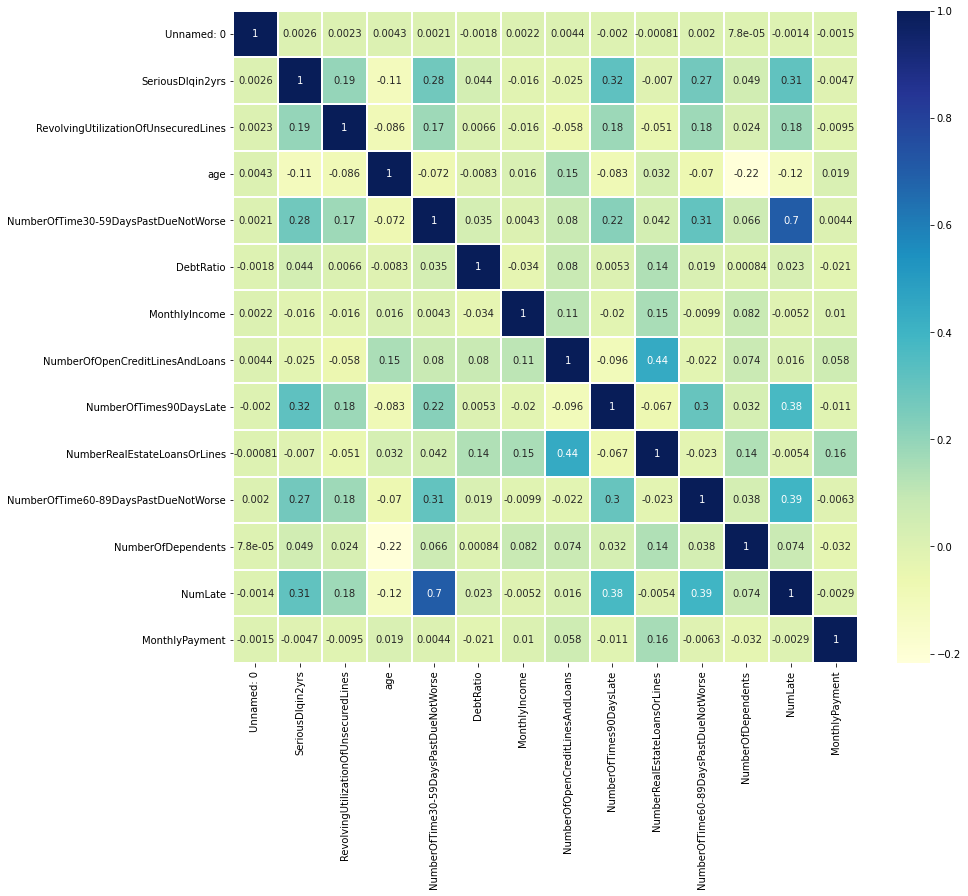

In [46]:
# 变量相关性
corr=df_train.corr()
plt.figure(figsize=(14,12))
sns.heatmap(corr,annot=True,linewidths=.3,cmap='YlGnBu')

##### WOE、IV值计算<a class="anchor" id="4c2"></a>

| IV | 预测能力 |
| :---: | :---: |
| < 0.03 | 无预测能力 |
| 0.03 ~ 0.09 | 低 |
| 0.1 ~ 0.29 | 中 |
| 0.3 ~ 0.49 | 高 |
| >= 0.5 | 极高 |

In [47]:
def bin_woe(tar, var, n=None, cat=None):
    """
    连续自变量分箱,woe,iv变换
    tar:target目标变量
    var:进行woe,iv转换的自变量
    n:分组数量
    """
    total_bad = tar.sum()
    total_good =tar.count()-total_bad
    totalRate = total_good/total_bad
    
    if cat == 's':
        msheet = pd.DataFrame({tar.name:tar,var.name:var,'var_bins':pd.qcut(var, n, duplicates='drop')})
        grouped = msheet.groupby(['var_bins'])
    elif (cat == 'd') and (n is None):
        msheet = pd.DataFrame({tar.name:tar,var.name:var})
        grouped = msheet.groupby([var.name])
        
    groupBad = grouped.sum()[tar.name]
    groupTotal = grouped.count()[tar.name]
    groupGood = groupTotal - groupBad
    groupRate = groupGood/groupBad
    groupBadRate = groupBad/groupTotal
    groupGoodRate = groupGood/groupTotal

    woe = np.log(groupRate/totalRate)
    iv = np.sum((groupGood/total_good-groupBad/total_bad)*woe)
    
    if cat == 's':
        new_var, cut = pd.qcut(var, n, duplicates='drop',retbins=True, labels=woe.tolist())
    elif cat == 'd':
        dictmap = {}
        for x in woe.index:
            dictmap[x] = woe[x]
        new_var, cut = var.map(dictmap), woe.index
    
    return woe.tolist(), iv, cut, new_var

In [48]:
df_train.columns

Index(['Unnamed: 0', 'SeriousDlqin2yrs',
       'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'NumLate', 'MonthlyPayment'],
      dtype='object')

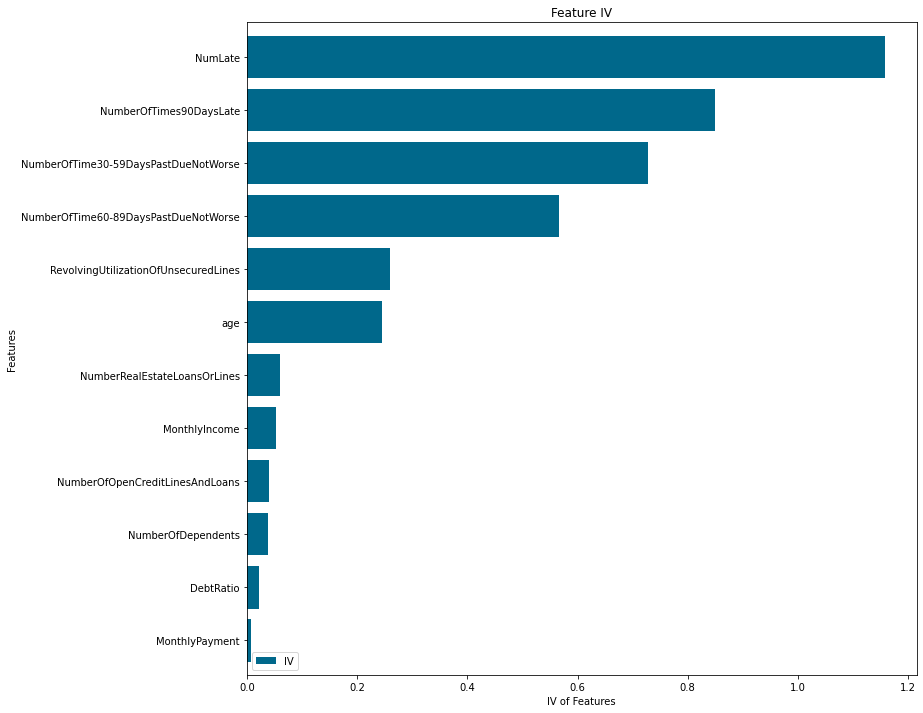

In [49]:
# 确定变量类型，连续变量还是离散变量
dvar = ['RevolvingUtilizationOfUnsecuredLines',
        'DebtRatio',
        'NumberOfTime30-59DaysPastDueNotWorse',
        'NumberOfTime60-89DaysPastDueNotWorse',
        'NumberOfTimes90DaysLate',
        'NumLate',
        'NumberRealEstateLoansOrLines',
        'NumberOfDependents']

svar = ['MonthlyIncome','age','MonthlyPayment','NumberOfOpenCreditLinesAndLoans']

# 可视化woe得分和iv得分
def woe_vs(data):
    cutdict = {}
    ivdict = {}
    woe_dict = {}
    woe_var = pd.DataFrame()
    for var in data.columns:
        if var in dvar:
            woe, iv, cut, new = bin_woe(data['SeriousDlqin2yrs'], data[var], cat='d')
            woe_dict[var] = woe
            woe_var[var] = new
            ivdict[var] = iv
            cutdict[var] = cut
        elif var in svar:
            woe, iv, cut, new = bin_woe(data['SeriousDlqin2yrs'], data[var], n=5, cat='s')
            woe_dict[var] = woe
            woe_var[var] = new
            ivdict[var] = iv
            cutdict[var] = cut
            
    ivdict = sorted(ivdict.items(), key=lambda x:x[1], reverse=False)
    iv_vs = pd.DataFrame([x[1] for x in ivdict],index=[x[0] for x in ivdict],columns=['IV'])
    ax = iv_vs.plot(kind='barh',
                    figsize=(12,12),
                    title='Feature IV',
                    fontsize=10,
                    width=0.8,
                    color='#00688B')
    ax.set_ylabel('Features')
    ax.set_xlabel('IV of Features')
    
    return ivdict, woe_var, woe_dict, cutdict

# woe转化
ivinfo, woe_data, woe_dict, cut_dict = woe_vs(df_train)

筛选出IV值大于0.1的变量：

- NumLate
- NumberOfTimes90DaysLate
- *NumberOfTime30-59DaysPastDueNotWorse*
- NumberOfTime60-89DaysPastDueNotWorse
- RevolvingUtilizationOfUnsecuredLines
- age

根据变量的相关性，NumLate 与 NumberOfTime30-59DaysPastDueNotWorse 相关系数0.7，强相关，舍去变量 NumberOfTime30-59DaysPastDueNotWorse。


### 模型构建<a class="anchor" id="5"></a>

#### 数据集切分<a class="anchor" id="5a"></a>

In [50]:
# 分离训练集和验证集
from sklearn.model_selection import train_test_split
selected_columns=['NumLate','NumberOfTimes90DaysLate','NumberOfTime60-89DaysPastDueNotWorse','RevolvingUtilizationOfUnsecuredLines','age']
X=woe_data[selected_columns]
y=df_train['SeriousDlqin2yrs']
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42)

#### 逻辑回归模型<a class="anchor" id="5b"></a>

In [51]:
# Logistic模型建立
from sklearn.linear_model import LogisticRegression

# model=LogisticRegression(random_state=0,
#                            solver="sag",
#                            penalty="l2",
#                            class_weight="balanced",
#                            C=1.0,
#                            max_iter=500)
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)
model_proba = model.predict_proba(X_test)#predict_proba返回的结果是一个数组，包含两个元素，第一个元素是标签为0的概率值，第二个元素是标签为1的概率值
model_score=model_proba[:,1]

In [52]:
model.score(X_test, y_test)

0.9358854486682874

### 模型评估<a class="anchor" id="6"></a>

#### ROC曲线、AUC值<a class="anchor" id="6a"></a>

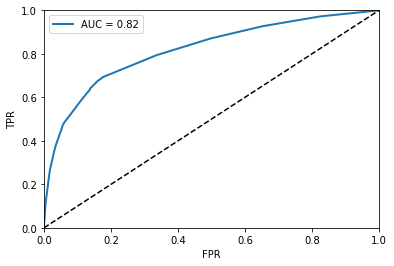

In [53]:
#绘制ROC曲线，计算AUC值
from sklearn.metrics import roc_curve, roc_auc_score
fpr,tpr,thresholds =roc_curve(y_test, model_score)
auc_score=roc_auc_score(y_test,model_score)
plt.plot(fpr, tpr, linewidth=2, label='AUC = %0.2f'%auc_score)
plt.plot([0,1],[0,1], "k--")
plt.axis([0,1,0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

### 评分卡<a class="anchor" id="6a"></a>

#### 参数换算

设定比率$\theta_0$的特定点的分值为$P_0$，$2\theta_0$的分值点为$P_0 + PDO$。

$$P_0 = A - B * log(\theta_0)$$
$$P_0 + PDO = A - B * log(2\theta_0)$$

解方程，得到常数$A,B$：

$$B = PDO / log(2)$$
$$A = P_0 + B * log(\theta_0)$$

设$P_0=600,PDO=20,\theta_0=1/60$，即当比率为1:60(对应违约率1.64%)时，将分值设为600分，加20分，对应的违约概率减半。解得：

In [54]:
B = 20/np.log(2)
A = 600 + B*np.log(1/60)
print("A={}, B={}".format(A,B))

A=481.8621880878296, B=28.85390081777927


In [55]:
intercept=model.intercept_
coef=model.coef_.flatten().tolist()
df_coef=pd.DataFrame({'feature':selected_columns,'coef':coef})

In [56]:
df_coef

,feature,coef
0,NumLate,-0.627100
1,NumberOfTimes90DaysLate,-0.474766
2,NumberOfTime60-89DaysPastDueNotWorse,-0.357322
3,RevolvingUtilizationOfUnsecuredLines,-0.475957
4,age,-0.679136


#### 评分卡生成

In [57]:
# 基础分
score = round(A-B*intercept[0],0)
score

558.0

In [58]:
cut_dict

{'RevolvingUtilizationOfUnsecuredLines': Float64Index([0.0, 1.0], dtype='float64', name='RevolvingUtilizationOfUnsecuredLines'),
 'age': array([ 21.,  39.,  48.,  56.,  65., 109.]),
 'NumberOfTime30-59DaysPastDueNotWorse': Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype='int64', name='NumberOfTime30-59DaysPastDueNotWorse'),
 'DebtRatio': Float64Index([0.0, 1.0], dtype='float64', name='DebtRatio'),
 'MonthlyIncome': array([0.00000e+00, 2.38200e+03, 4.00000e+03, 5.92000e+03, 8.37700e+03,
        3.00875e+06]),
 'NumberOfOpenCreditLinesAndLoans': array([ 0.,  4.,  6.,  9., 12., 36.]),
 'NumberOfTimes90DaysLate': Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype='int64', name='NumberOfTimes90DaysLate'),
 'NumberRealEstateLoansOrLines': Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype='int64', name='NumberRealEstateLoansOrLines'),
 'NumberOfTime60-89DaysPastDueNotWorse': Int64Index([0, 1, 2, 3, 4, 5, 6, 7], dtype='int64', name='NumberOfTime60-89DaysPastDueNotWorse'),
 'NumberOfDependents': In

In [59]:
woe_dict

{'RevolvingUtilizationOfUnsecuredLines': [0.1192313100488483,
  -2.2264112572193975],
 'age': [-0.4871831280687727,
  -0.25255703624491094,
  -0.07829209771025719,
  0.4301233835035746,
  1.0541680947582983],
 'NumberOfTime30-59DaysPastDueNotWorse': [0.5278296917051442,
  -0.9176184609272902,
  -1.630617320845461,
  -2.0413861362550736,
  -2.3507607419306393,
  -2.4506769176621597,
  -2.764576629256224,
  -2.7242742502322015,
  -2.244701169970315],
 'DebtRatio': [0.030052578148372425, -0.749995396359342],
 'MonthlyIncome': [-0.033300700391121936,
  -0.33642946921766287,
  -0.09943535174949214,
  0.15905251049018698,
  0.3817514072996404],
 'NumberOfOpenCreditLinesAndLoans': [-0.31844287666651216,
  0.11456424939282875,
  0.20770482357731448,
  0.10849776673108649,
  -0.011341137621030463],
 'NumberOfTimes90DaysLate': [0.3758252287402818,
  -1.9718595525316482,
  -2.64630775239095,
  -2.96150254142815,
  -3.35881764517439,
  -3.1978058749671865,
  -3.055631386186644,
  -4.13824333350831

In [60]:
# 分箱区间转换
def cut_to_bin(cutlist):
    cutlist_right = cutlist[1:] + ['inf']
    binlist = ["[{},{})".format(a,b) for a,b in zip(cutlist,cutlist_right)]
    return binlist

def cut_to_bin2(cutlist):
    cutlist_left = ['-inf'] + cutlist[:-1]
    binlist = ["[{},{})".format(a,b) for a,b in zip(cutlist_left,cutlist)]
    return binlist

df_bins = cut_dict.copy()
bins=[]
for k,cutlist in cut_dict.items():
    if k == 'age':
        binlist = cut_to_bin2(list(cutlist))
    else:
        binlist = cut_to_bin(list(cutlist))
    bins.append(binlist)
    df_bins[k]=binlist
    
df_bins

{'RevolvingUtilizationOfUnsecuredLines': ['[0.0,1.0)', '[1.0,inf)'],
 'age': ['[-inf,21.0)',
  '[21.0,39.0)',
  '[39.0,48.0)',
  '[48.0,56.0)',
  '[56.0,65.0)',
  '[65.0,109.0)'],
 'NumberOfTime30-59DaysPastDueNotWorse': ['[0,1)',
  '[1,2)',
  '[2,3)',
  '[3,4)',
  '[4,5)',
  '[5,6)',
  '[6,7)',
  '[7,8)',
  '[8,inf)'],
 'DebtRatio': ['[0.0,1.0)', '[1.0,inf)'],
 'MonthlyIncome': ['[0.0,2382.0)',
  '[2382.0,4000.0)',
  '[4000.0,5920.0)',
  '[5920.0,8377.0)',
  '[8377.0,3008750.0)',
  '[3008750.0,inf)'],
 'NumberOfOpenCreditLinesAndLoans': ['[0.0,4.0)',
  '[4.0,6.0)',
  '[6.0,9.0)',
  '[9.0,12.0)',
  '[12.0,36.0)',
  '[36.0,inf)'],
 'NumberOfTimes90DaysLate': ['[0,1)',
  '[1,2)',
  '[2,3)',
  '[3,4)',
  '[4,5)',
  '[5,6)',
  '[6,7)',
  '[7,8)',
  '[8,9)',
  '[9,10)',
  '[10,inf)'],
 'NumberRealEstateLoansOrLines': ['[0,1)',
  '[1,2)',
  '[2,3)',
  '[3,4)',
  '[4,5)',
  '[5,6)',
  '[6,7)',
  '[7,8)',
  '[8,inf)'],
 'NumberOfTime60-89DaysPastDueNotWorse': ['[0,1)',
  '[1,2)',
  '[2,3)',
  

In [61]:
features = []
woelist = []
binlist = []

for k,v in woe_dict.items():
    if k in selected_columns:
        for n in range(0,len(v)):
            features.append(k)
            woelist.append(v[n])
            
            binlist.append(df_bins[k][n])
            

scoreboard = pd.DataFrame({'feature':features,'woe':woelist,'bins':binlist},
                          columns=['feature','bins','woe'])

score_card = pd.merge(scoreboard, df_coef)
score_card['score'] = round(-B*score_card['woe']*score_card['coef'],0)
score_card.drop('coef',axis=1,inplace=True)
score_card

,feature,bins,woe,score
0,RevolvingUtilizationOfUnsecuredLines,"[0.0,1.0)",0.119231,2.0
1,RevolvingUtilizationOfUnsecuredLines,"[1.0,inf)",-2.226411,-31.0
2,age,"[-inf,21.0)",-0.487183,-10.0
3,age,"[21.0,39.0)",-0.252557,-5.0
4,age,"[39.0,48.0)",-0.078292,-2.0
5,age,"[48.0,56.0)",0.430123,8.0
6,age,"[56.0,65.0)",1.054168,21.0
7,NumberOfTimes90DaysLate,"[0,1)",0.375825,5.0
8,NumberOfTimes90DaysLate,"[1,2)",-1.971860,-27.0
9,NumberOfTimes90DaysLate,"[2,3)",-2.646308,-36.0


为了方便查看，这里再分组排序下，每组按照分值的高低：

In [62]:
scorecard_sorted = score_card.groupby('feature').apply(lambda x: x.sort_values('score', ascending=False))
scorecard_sorted

feature  \
feature                                                                         
NumLate                              26                               NumLate   
                                     27                               NumLate   
NumberOfTime60-89DaysPastDueNotWorse 18  NumberOfTime60-89DaysPastDueNotWorse   
                                     19  NumberOfTime60-89DaysPastDueNotWorse   
                                     20  NumberOfTime60-89DaysPastDueNotWorse   
                                     25  NumberOfTime60-89DaysPastDueNotWorse   
                                     21  NumberOfTime60-89DaysPastDueNotWorse   
                                     22  NumberOfTime60-89DaysPastDueNotWorse   
                                     23  NumberOfTime60-89DaysPastDueNotWorse   
                                     24  NumberOfTime60-89DaysPastDueNotWorse   
NumberOfTimes90DaysLate              7                NumberOfTimes90DaysLate   
                                     8                NumberOfTimes90DaysLate   
                                     9                NumberOfTimes90DaysLate   
                                     17               NumberOfTimes90DaysLate   
                                     10               NumberOfTimes90DaysLate   
                                     13               NumberOfTimes90DaysLate   
                                     12               NumberOfTimes90DaysLate   
                                     11               NumberOfTimes90DaysLate   
                                     15               NumberOfTimes90DaysLate   
                                     16               NumberOfTimes90DaysLate   
                                     14               NumberOfTimes90DaysLate   
RevolvingUtilizationOfUnsecuredLines 0   RevolvingUtilizationOfUnsecuredLines   
                                     1   RevolvingUtilizationOfUnsecuredLines   
age                                  6                                    age   
                                     5                                    age   
                                     4                                    age   
                                     3                                    age   
                                     2                                    age   

                                                bins       woe  score  
feature                                                                
NumLate                              26        [0,1)  0.923681   17.0  
                                     27      [1,inf) -1.383442  -25.0  
NumberOfTime60-89DaysPastDueNotWorse 18        [0,1)  0.274309    3.0  
                                     19        [1,2) -1.850365  -19.0  
                                     20        [2,3) -2.657322  -27.0  
                                     25      [7,inf) -2.804317  -29.0  
                                     21        [3,4) -2.915869  -30.0  
                                     22        [4,5) -3.135674  -32.0  
                                     23        [5,6) -3.129739  -32.0  
                                     24        [6,7) -3.748779  -39.0  
NumberOfTimes90DaysLate              7         [0,1)  0.375825    5.0  
                                     8         [1,2) -1.971860  -27.0  
                                     9         [2,3) -2.646308  -36.0  
                                     17     [10,inf) -2.817220  -39.0  
                                     10        [3,4) -2.961503  -41.0  
                                     13        [6,7) -3.055631  -42.0  
                                     12        [5,6) -3.197806  -44.0  
                                     11        [4,5) -3.358818  -46.0  
                                     15        [8,9) -3.566457  -49.0  
                                     16       [9,10) -3.679786  -50.0  
                                     14        [7,8) -4

总体来说评分符合预期，例如NumberOfTime60-89DaysPastDueNotWorses越高，给的分数越低。

#### 评分卡应用

In [63]:
# 将输入数据映射到分箱，并且选取相应的分值来计算最后的信用评分
def str_to_int(s):
    if s == '-inf':
        return -999999999.0
    elif s=='inf':
        return 999999999.0
    else:
        return float(s)
    
def map_value_to_bin(feature_value,feature_to_bin):
    for idx, row in feature_to_bin.iterrows():
        bins = str(row['bins'])
        left_open = bins[0]=="("
        right_open = bins[-1]==")"
        binnings = bins[1:-1].split(',')
        in_range = True
        # check left bound
        if left_open:
            if feature_value<= str_to_int(binnings[0]):
                in_range = False   
        else:
            if feature_value< str_to_int(binnings[0]):
                in_range = False   
        #check right bound
        if right_open:
            if feature_value>= str_to_int(binnings[1]):
                in_range = False 
        else:
            if feature_value> str_to_int(binnings[1]):
                in_range = False   
        if in_range:
            return row['bins']
    return None

def map_to_score(df,score_card):
    scored_columns = list(score_card['feature'].unique())
    score = 0
    for col in scored_columns:
        feature_to_bin = score_card[score_card['feature']==col]
        feature_value = df[col]
        selected_bin = map_value_to_bin(feature_value,feature_to_bin)
        selected_record_in_scorecard = feature_to_bin[feature_to_bin['bins'] == selected_bin]
        score += selected_record_in_scorecard['score'].iloc[0]
    return score  

def calculate_score_with_card(df,score_card,A):
    df['score'] = df.apply(map_to_score,args=(score_card,),axis=1)
    df['score'] = df['score']+A
    df['score'] = df['score'].astype(int)
    return df

In [64]:
good_sample = df_train[df_train['SeriousDlqin2yrs']==0].sample(5, random_state=1)
good_sample = good_sample[selected_columns]
bad_sample = df_train[df_train['SeriousDlqin2yrs']==1].sample(5, random_state=1)
bad_sample = bad_sample[selected_columns]

In [65]:
#calculate_score_with_card(good_sample,score_card,A)

In [66]:
calculate_score_with_card(bad_sample,score_card,A)

,NumLate,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,RevolvingUtilizationOfUnsecuredLines,age,score
75002,0,0,0,0.0,44,506
42079,1,2,0,0.0,51,433
132295,0,0,0,0.0,44,506
87494,0,0,0,0.0,47,506
83105,1,0,1,0.0,34,439


### 参考链接<a class="anchor" id="8"></a>

- https://www.kaggle.com/c/GiveMeSomeCredit/data
- https://www.kaggle.com/orange90/credit-scorecard-example
- https://zhuanlan.zhihu.com/p/50051580
- https://www.jianshu.com/p/f60c9a7a3ec8
- https://zhuanlan.zhihu.com/p/31229720
- https://blog.csdn.net/PbGc396Dwxjb77F2je/article/details/78786994